### Netflix is one of the world's leading entertainment services with 204 million paid memberships in over 190 countries enjoying TV series, documentaries and feature films across a wide variety of genres and languages. In this notebook we will explore the data on TV Shows and Movies available on Netflix worldwide. First we will do some Exploratory Data Analysis (EDA) to know and describe the data in a better way through interactive graphs and visualizations. Then we will build a multilabel classifier using BERT and MLP to predict the Genre of a show using its description.


Please upvote the notebook if you like it and suggest improvements in the comments.



![](https://haasentertainment.com/wp-content/uploads/2019/11/ReflectingNeglectedBug-size_restricted.gif)

In [3]:
!wget 'https://raw.githubusercontent.com/SarthakV7/covid_dashboard/master/data/country_to_iso.csv'

import numpy as np
import pandas as pd
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import warnings

warnings.filterwarnings('ignore')
sns.set()

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
df = pd.read_csv('../input/netflix-shows/netflix_titles.csv')

--2021-02-15 11:17:23--  https://raw.githubusercontent.com/SarthakV7/covid_dashboard/master/data/country_to_iso.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12720 (12K) [text/plain]
Saving to: ‘country_to_iso.csv’

country_to_iso.csv  100%[===================>]  12.42K  --.-KB/s    in 0s      

2021-02-15 11:17:24 (70.2 MB/s) - ‘country_to_iso.csv’ saved [12720/12720]

/kaggle/input/netflix-shows/netflix_titles.csv


## Let's begin by taking a look at the dataset

In [3]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


#### The dataset has 7787 rows and 12 columns:
* **show_id:** unique id of each show (not much of a use for us in this notebook)
* **type:** The category of a show, can be either a Movie or a TV Show
* **title:** Name of the show
* **director:** Name of the director(s) of the show
* **cast:** Name of actors and other cast of the show
* **country:** Name of countries the show is available to watch on Netflix
* **date_added:** Date when the show was added on Netflix
* **release_year:** Release year of the show
* **rating:** Show rating on netflix
* **duration:** Time duration of the show
* **listed_in:** Genre of the show
* **description:** Some text describing the show

## How about the number of shows available worldwide in each country?

In [4]:
iso = pd.read_csv('country_to_iso.csv')[['Country','Alpha-3 code']]
df_map = pd.DataFrame()
x = np.hstack([np.array(i.split(',')) for i in df.country.dropna()])
unique, counts = np.unique(x, return_counts=True)        
df_map['Country'] = unique
df_map['count'] = counts
df_map = df_map.merge(iso, how='left', on='Country').dropna()
df_map['Alpha-3 code'] = df_map['Alpha-3 code'].apply(lambda x:x[2:-1])

fig = go.Figure(data=go.Choropleth(locations=df_map['Alpha-3 code'],
                                    z=df_map['count'].astype(float),
                                    colorscale='viridis',
                                    text=df_map['Country'],
                                    marker_line_color='black',
                                    colorbar_title = 'number of shows'))

# fig.update_geos(projection_type="orthographic")
                
fig.show()

In [5]:
fig = px.pie(df_map.sort_values('count', ascending=False).iloc[:20], values='count', 
             names='Country', title='Shows available in different countries (top 20)')
fig.show()

#### A majority of shows are available in the US (2883 shows), followed by India (956 shows), UK (577 shows), Canada (259 shows), Japan (237 shows), France(196 shows)...

## Number of Movies or TV Shows?

In [6]:
fig = px.histogram(df, x='type')
fig.show()

#### There are 5377 Movies and 2410 TV Shows available on Netflix all across the world.

## Number of shows (Movies + TV Shows) released every year

In [7]:
fig = px.histogram(df, x='release_year')
fig.show()

#### The number of shows have been rapidly increasing each year achieving a maximum in 2018 (1121 Shows!) followed by a dip in 2019 (996 Shows) and 2020 (868 Shows).

## Number of shows (Movies + TV Shows) added to Netflix every year

In [8]:
fig = px.histogram([int(i.split(', ')[1]) for i in df.date_added.dropna()], orientation='h', labels={'value':'year'})
fig.show()

#### The number of shows have been rapidly increasing each year achieving a maximum in 2019 (2153 Shows!) followed by a dip 2020 (2009 Shows).

## Here are the top 10 oldest shows available on Netflix

In [9]:
df.sort_values('release_year')[['title', 'type', 'country', 'director', 'cast', 'release_year']].dropna().head(10)

,title,type,country,director,cast,release_year
6117,The Battle of Midway,Movie,United States,John Ford,"Henry Fonda, Jane Darwell",1942
7268,Tunisian Victory,Movie,"United States, United Kingdom","Frank Capra, John Huston, Hugh Stewart, Roy Bo...",Burgess Meredith,1944
3425,Know Your Enemy - Japan,Movie,United States,"Frank Capra, Joris Ivens","Walter Huston, Dana Andrews",1945
3608,Let There Be Light,Movie,United States,John Huston,Walter Huston,1946
7072,Thunderbolt,Movie,United States,"William Wyler, John Sturges","James Stewart, Lloyd Bridges",1947
7595,White Christmas,Movie,United States,Michael Curtiz,"Bing Crosby, Danny Kaye, Rosemary Clooney, Ver...",1954
6141,The Blazing Sun,Movie,Egypt,Youssef Chahine,"Omar Sharif, Faten Hamama, Zaki Rostom, Farid ...",1954
6868,The Sign of Venus,Movie,Italy,Dino Risi,"Sophia Loren, Franca Valeri, Vittorio De Sica,...",1955
5425,Scandal in Sorrento,Movie,"Italy, France",Dino Risi,"Vittorio De Sica, Sophia Loren, Lea Padovani, ...",1955
5122,Rebel Without a Cause,Movie,United States,Nicholas Ray,"James Dean, Natalie Wood, Sal Mineo, Jim Backu...",1955


## Content ratings of the shows

In [10]:
fig = px.funnel(df.rating.value_counts(), labels={'index':'rating type'})
fig.show()

**The largest count of shows are made with the 'TV-MA' rating (2863 shows)**
"TV-MA": For mature audiences only.

**Second largest is the 'TV-14' rating (1931 shows)**
"TV-14": May be inappropriate for children younger than 14 years of age.

**Third largest is the 'TV-PG' rating (806 shows)**
"TV-PG": Parental guidance suggested

**Fourth largest is the very popular 'R' rating (665 shows)**
"R": May be unsuitable for children under the age of 17 (Under 17 requires accompanying parent or adult guardian")

## How long is a movie?
### Histogram of duration of movies.

In [11]:
grp = df.groupby('type')
movie = grp.get_group('Movie')
movie['duration'] = [int(i.split(' ')[0]) for i in movie.duration.dropna()]
fig = px.histogram(movie, x='duration', nbins=60, labels={'duration':'duration (in mins)'})
fig.show()

Looks like a majority of the shows are between 90 and 99 mins. The distribution takes a bell shaped curve, let's use violin plot and box-plot to get a better idea about the data

### Violin and box-plot representation of movie duration

In [12]:
movie = grp.get_group('Movie')
movie['duration'] = [int(i.split(' ')[0]) for i in movie.duration.dropna()]
fig = px.violin(movie, x='duration', box=True, points="all", labels={'duration':'duration (in mins)'})
fig.show()

Alright! The median movie length is 97 mins, 50% of the movies have a duration between 86 mins and 114 mins.
Shortest movie available on netflix is 3 mins long whereas the longest movie available on netflix is 312 mins long!

### Top 20 shortest movies available on Netflix

In [13]:
#longest movie
fig = px.bar(movie.sort_values('duration')[['title', 'duration']].iloc[:20], x='title', y='duration',
             labels={'index':'Director', 'value':'movie count'})
fig.show()

There are 13 movies that are less than 15 mins long, the shortest movie being **Silent** (3 mins) followed by **Sol Levante** (5 mins) and **Cops and Robbers** (8 mins).

Below are some more details on these 3 movies from the dataset.

In [14]:
movie.sort_values('duration')[['title', 'director', 'country', 'rating', 'duration', 'description']].iloc[:3]

,title,director,country,rating,duration,description
5605,Silent,"Limbert Fabian, Brandon Oldenburg",United States,TV-Y,3,"""Silent"" is an animated short film created by ..."
5694,Sol Levante,Akira Saitoh,Japan,TV-14,5,A young warrior and her familiar search for th...
1501,Cops and Robbers,"Arnon Manor, Timothy Ware-Hill",United States,PG-13,8,Animation and activism unite in this multimedi...


### Top 20 longest movies available on Netflix

In [15]:
fig = px.bar(movie.sort_values('duration')[['title', 'duration']].iloc[-20:], x='title', y='duration',
             labels={'title':'Movie name'})
fig.show()

There are 15 movies that are more than 200 mins long, the longest movie being **Black Mirror: Bandersnatch** (312 mins) followed by **The School of Mischief** (253 mins) and **No Longer kids** (237 mins).

Below are some more details on these 3 movies from the dataset.

In [16]:
movie.sort_values('duration')[['title', 'director', 'country', 'rating', 'duration', 'description']].iloc[-3:]

,title,director,country,rating,duration,description
4490,No Longer kids,Samir Al Asfory,Egypt,TV-14,237,Hoping to prevent their father from skipping t...
6850,The School of Mischief,Houssam El-Din Mustafa,Egypt,TV-14,253,A high school teacher volunteers to transform ...
957,Black Mirror: Bandersnatch,NaN,United States,TV-MA,312,"In 1984, a young programmer begins to question..."


## How many seasons do TV Shows on Netflix have?
### Histogram of number of seasons of TV Shows.

In [17]:
tv_series = grp.get_group('TV Show')
tv_series['duration'] = [int(i.split(' ')[0]) for i in tv_series.duration]
fig = px.histogram(tv_series, x='duration', nbins=20, labels={'duration':'number of seasons'})
fig.show()

Most of the TV Shows (1608 shows) have a single season whereas much lesser shows have more than 1 seasons on Netflix.

### Let's take a look at the top 25 TV Shows on Netflix with the most number of seasons

In [18]:
dd = df[df['type']=='TV Show'][['title', 'duration']]
dd['duration'] = [int(i.split(' ')[0]) for i in dd.duration]
fig = px.bar(dd.sort_values('duration', ascending=False).iloc[:25], x='title', y='duration',
             labels={'title':'TV series name', 'duration':'number of seasons'})
fig.show()

Gery's Anatomy leads with 16 seasons available on Netflix followed by NCIS and Supernatural (15 seasons both).

## Who has directed most number of movies?
### Top 20 directors who've directed the most number of movies.

In [19]:
dd = pd.DataFrame()
dd['director'] = [f'{i} ({j})' for i,j in df[['director', 'country']].dropna().values]
fig = px.bar(dd.director.value_counts()[:20], labels={'index':'Director', 'value':'movie count'})
fig.show()

Marcus Raboy has 15 shows listed on Netflix followed by Jay Karas (14 shows) and then Cathy Garcia-Molina (13 shows).

![](https://m.media-amazon.com/images/M/MV5BNTgyNzk2Njc4Ml5BMl5BanBnXkFtZTgwOTM0ODEyMjE@._V1_UY317_CR53,0,214,317_AL__QL50.jpg)
Since the early 1990s, Raboy has amassed a large number music video credits directing music videos for Mary J. Blige, Dixie Chicks, Rihanna, Luther Vandross, Shakira, Santana, and Westlife among other notable artists.
His feature film credits are Friday After Next (2002) and Janky Promoters (2009) both starring Ice Cube and Mike Epps.
Raboy grew up in New York City and attended New York University. He is managed by David Naylor & Associates and currently resides in Los Angeles, California.

![](https://resizing.flixster.com/85hGP2DnnYs2Fy299eGAA3g5j_g=/300x300/v2/http://media.baselineresearch.com/images/1238751/1238751_full.jpg)
Jay Karas's resume primarily consists of directing live telecasts and stand-up comedy specials. In recent years he moved on to directing episodic television, directing episodes of Parks and Recreation, Raising Hope, Awkward, The Fosters, Brooklyn Nine-Nine and Workaholics. In 2014, Karas made his feature film directing debut with the film Break Point, starring Jeremy Sisto and David Walton.
Karas's episode of Dice was one of The Hollywood Reporter's "Critics' Picks: The 15 Best TV Episodes of 2016" and Teachers made Vanity Fair's "5 Underrated TV Shows You Should Watch Right Now".

![](https://assets.mubicdn.net/images/cast_member/181323/image-w240.jpg)
Catherine Rosales Garcia-Molina (born November 28, 1971) is a Filipino film and television director best known for directing romantic comedy films produced and distributed by Star Cinema. She has also directed a few TV series, which aired on ABS-CBN. Some of her films were considered top-grossers in the Philippines.
Her 2019 film, Hello, Love, Goodbye, starring Kathryn Bernardo and Alden Richards, was released in July and has become the highest grossing Philippine film of all time.

## Who has acted in most number of shows?
#### Top 25 actors who've casted the most in shows.

In [22]:
dd = pd.DataFrame()
dd['cast'] = np.hstack([np.array(i.split(',')) for i in df.cast.dropna()])
fig = px.bar(dd.cast.value_counts()[:25], labels={'index':'cast', 'value':'movie count'})
fig.show()

Anupam Kher has casted in most number of shows (38 shows) on Netflix, followed by Takahiro Sakurai (28 shows) and then Shah Rukh Khan (27 shows).

![](https://upload.wikimedia.org/wikipedia/commons/b/b9/AnupamKher2.jpg)
Anupam Kher (born 7 March 1955) is an Indian actor and the former Chairman of Film and Television Institute of India. He is the recipient of two National Film Awards and eight Filmfare Awards. He has appeared in over 500 films predominantly in Hindi language, and many plays. He won the Filmfare Award for Best Actor for his performance in Saaransh (1984). He holds the record for winning the Filmfare Award for Best Comedian five times in total for: Ram Lakhan (1989), Lamhe (1991), Khel (1992), Darr (1993) and Dilwale Dulhaniya Le Jayenge (1995).

![](https://m.media-amazon.com/images/M/MV5BZmIyMGYyOTYtMGQ5OS00MWM3LWIxNzUtYTkyOWExOWQ4YjhiXkEyXkFqcGdeQXVyNDQxNjcxNQ@@._V1_UY317_CR21,0,214,317_AL__QL50.jpg)
Takahiro Sakurai (櫻井 孝宏, Sakurai Takahiro, born June 13, 1974) is a Japanese voice actor associated with Intention. Notable roles that Sakurai has portrayed include Giyū Tomioka from Demon Slayer: Kimetsu no Yaiba, Tentomon from the Digimon Adventure series, Zombieman from One Punch Man, Sting Eucliffe from Fairy Tail, Sasori from Naruto Shippuden, Cloud Strife in Compilation of Final Fantasy VII, Licht/Patry from Black Clover, and Osomatsu Matsuno from Osomatsu-san.

![](https://in.bmscdn.com/iedb/artist/images/website/poster/large/shah-rukh-khan-2092-12-09-2017-02-10-43.jpg)
Shah Rukh Khan (born 2 November 1965), also known by the initialism SRK, is an Indian actor, film producer, and television personality. Referred to in the media as the "Baadshah of Bollywood" (in reference to his 1999 film Baadshah), "King of Bollywood" and "King Khan", he has appeared in more than 80 Hindi films, and earned numerous accolades, including 14 Filmfare Awards. The Government of India has awarded him the Padma Shri, and the Government of France has awarded him the Ordre des Arts et des Lettres and the Legion of Honour. Khan has a significant following in Asia and the Indian diaspora worldwide. In terms of audience size and income, he has been described as one of the most successful film stars in the world.

## Genre of the shows available on Netflix
### Bar plot of show genre and number of corresponding shows

In [23]:
dd = pd.DataFrame()
dd['listed_in'] = np.hstack([np.array(i.split(', ')) for i in df.listed_in.dropna()])
fig = px.bar(dd.listed_in.value_counts(), labels={'index':'genre', 'value':'movie count'}, orientation='h')
fig.show()

Most of the shows belong to International Movies category followed by comedy, Documentaries and TV Dramas.

## Top words used in show description
### Wordcloud of words used in show descriptions

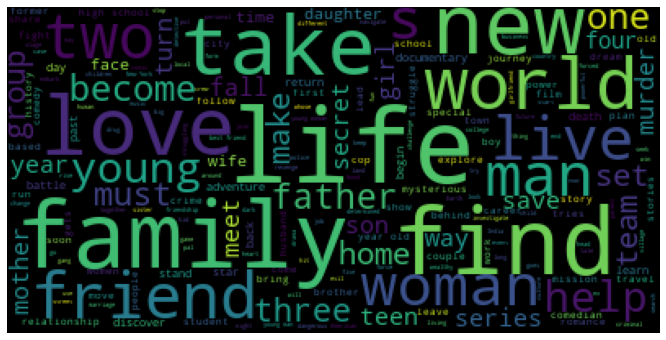

In [24]:
text = ' '.join(df.description.dropna().values)
wordcloud = WordCloud(background_color = 'black').generate(text)
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Seems like **life, family, find take, new, world** are some of the most common words used in describing the shows.

## Top words used in show title
### Wordcloud of words used in show title

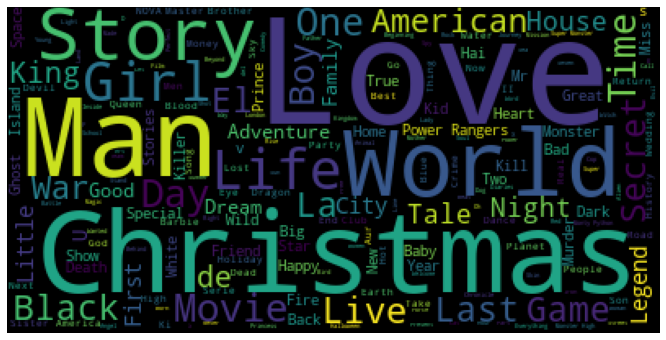

In [25]:
text = ' '.join(df.title.dropna().values)
wordcloud = WordCloud(background_color = 'black').generate(text)
plt.figure(figsize=(15, 6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Seems like **Christmas, man, love, life, story, girl** are some of the most common words used in describing the shows.

## Let's use some deep learning to predicting a show's genre based on its description

![](https://i.ibb.co/vxbyh33/Screen-Shot-2021-02-15-at-6-27-29-PM.png)

### I suggest that before proceeding, check out [my blog on BERT](https://towardsdatascience.com/understanding-bert-bidirectional-encoder-representations-from-transformers-45ee6cd51eef) to understand the futher steps better.

In this section, we'll be using transformers and MLP to predict a show's genre from its description text.
This will be a multilabel classification task.

Multi-label classification originated from the investigation of text categorisation problem, where each document may belong to several predefined topics simultaneously.

Multi-label classification of textual data is an important problem. Examples range from news articles to emails. For instance, this can be employed to find the genres that a movie belongs to, based on the summary of its plot.

### Approach:
We'll be using transfer learning to get embeddings from pretrained BERT for each show's description. 
Next, we'll be training a MLP from the generated embeddings to predict the show genre.

### Data:
The input data here will be show description and the output labels will be the 42 Genres.

**Input data:** This will be the text describing a show

**Output labels:** This will be a vector of size 42 (since there are 42 genres) having values 0 or 1. 0 corresponding to a genre not present and 1 corresponding a genre present

In [6]:
# function for creating output labels from show genre (the feature 'listed_in' in the dataset)
labels = np.hstack([np.array(i.split(', ')) for i in df.listed_in.dropna()])
unique = np.unique(labels)
def generate_label(x):
    genres = x.split(', ')
    label = np.zeros(shape=unique.shape)
    for i in genres:
        for j in range(len(unique)):
            if unique[j]==i:
                label[j]=1
    return label.astype(int)

Below is the prepared dataset that we'll be using in this task.
The column text holds show description text and the column label holds the 42 dimensional vector to be used as output labels

In [8]:
from tqdm.notebook import tqdm
data = pd.DataFrame()
data['text'] = df.dropna()['description']
data['title'] = df.dropna()['title']
data['label'] = [generate_label(x) for x in tqdm(df.dropna()['listed_in'])]
data[['text', 'label']].head()

  0%|          | 0/4808 [00:00<?, ?it/s]

,text,label
1,After a devastating earthquake hits Mexico Cit...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,"When an army recruit is found dead, his fellow...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,"In a postapocalyptic world, rag-doll robots hi...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,A brilliant group of students become card-coun...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
5,A genetics professor experiments with a treatm...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Let's begin by checking the word length of show descriptions so that we can trim and pad the texts to the same length for easy processing in the future steps.

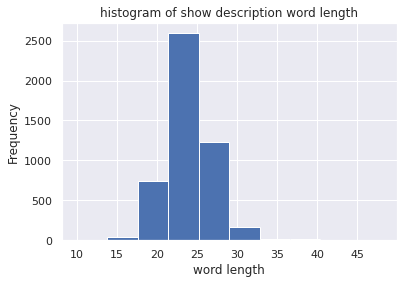

word length at 90 percentile: 27.0
word length at 91 percentile: 27.36999999999989
word length at 92 percentile: 28.0
word length at 93 percentile: 28.0
word length at 94 percentile: 28.0
word length at 95 percentile: 28.0
word length at 96 percentile: 29.0
word length at 97 percentile: 29.0
word length at 98 percentile: 29.0
word length at 99 percentile: 31.0


In [10]:
def get_wordlen(x): 
    return len(x.split())

data['len'] = data.text.apply(get_wordlen)
data['len'].plot(kind='hist')
plt.title('histogram of show description word length')
plt.xlabel('word length')
plt.show()
for i in np.arange(0.9,1,0.01):
    p = data.len.quantile(i)
    print(f'word length at {int(i*100)} percentile:',p)

Most of the texts (98%) are less than a length of 31, we'll be using 31 as the threshold value and making all the text of length 31 by truncating larger texts or by padding smaller texts.

### Let's divide our data into train, validation and test sets (70:15:15)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[['text', 'title']], data['label'], test_size=0.3, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=33)

In [17]:
y_train.shape, y_val.shape, y_test.shape

((3365,), (721,), (722,))

In [18]:
!pip install bert-tensorflow

     |████████████████████████████████| 64 kB 301 kB/s eta 0:00:01


In [19]:
# importing necessary libraries
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import Model
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Input
tf.get_logger().setLevel('ERROR')

### Creating a transformer model from pretrained BERT_EN_UNCASED

In [24]:
tf.keras.backend.clear_session()
max_seq_length = 31
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids" )
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False, name='BERT')
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=sequence_output)

In [25]:
bert_model.summary(), bert_model.output, bert_model.input

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 31)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 31)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 31)]         0                                            
__________________________________________________________________________________________________
BERT (KerasLayer)               [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

(None,
 <KerasTensor: shape=(None, None, 768) dtype=float32 (created by layer 'BERT')>,
 [<KerasTensor: shape=(None, 31) dtype=int32 (created by layer 'input_word_ids')>,
  <KerasTensor: shape=(None, 31) dtype=int32 (created by layer 'input_mask')>,
  <KerasTensor: shape=(None, 31) dtype=int32 (created by layer 'segment_ids')>])

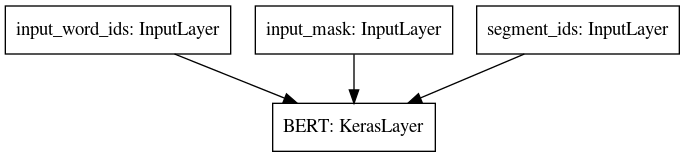

In [62]:
tf.keras.utils.plot_model(bert_model, show_shapes=False, show_dtype=False,
                          show_layer_names=True, rankdir='TB', 
                          expand_nested=False, dpi=96)

### Using tokenization to convert the description text into a format understood by BERT
We'll be creating 3 type of inputs from a given test:

* token_ids: The token embeddings are numerical representations of words in the input sentence.
* token_masks: The mask tokens that help BERT to understand what all input words are relevant and what all are just there for padding.
* token_segments: The segment embeddings are used to help BERT distinguish between the different sentences in a single input.

In [26]:
from bert import tokenization
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy() 
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [27]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def text_to_tokens(x):
    t = np.asarray(tokenizer.tokenize(x))
    if len(t)>max_seq_length-2:
        t = t[:max_seq_length-2]
    padding = np.asarray(['[PAD]']*(max_seq_length-t.shape[0]-2))
    pre, post = np.asarray(['[CLS]']), np.asarray(['[SEP]'])
    final = np.concatenate((pre,t,post,padding))
    ids = np.asarray(tokenizer.convert_tokens_to_ids(final))
    mask = (ids != 0)*1
    segment = np.zeros_like(ids)
    return ids, mask, segment

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [30]:
from tqdm.notebook import tqdm
# initializing lists to collect the generated tokens, masks and segments. 
X_train_tokens, X_val_tokens, X_test_tokens = [], [], []
X_train_mask, X_val_mask, X_test_mask = [], [], []
X_train_segment, X_val_segment, X_test_segment = [], [], []
# Generating and storing tokens, masks, segments values for X_train texts
for i,x in tqdm(enumerate(X_train.text.values)): 
    t,m,s = text_to_tokens(x) 
    X_train_tokens.append(t) 
    X_train_mask.append(m) 
    X_train_segment.append(s)
    
# Generating and storing tokens, masks, segments values for X_val texts
for i,x in tqdm(enumerate(X_val.text.values)): 
    t,m,s = text_to_tokens(x) 
    X_val_tokens.append(t) 
    X_val_mask.append(m) 
    X_val_segment.append(s)
    
# Generating and storing tokens, masks, segments values for X_test texts
for i,x in tqdm(enumerate(X_test.text.values)): 
    t,m,s = text_to_tokens(x) 
    X_test_tokens.append(t) 
    X_test_mask.append(m) 
    X_test_segment.append(s)

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

### Obtaining the numerical embeddings of text from BERT

In [31]:
# converting the tokens lists to array type
X_train_tokens = np.row_stack(X_train_tokens) 
X_val_tokens = np.row_stack(X_val_tokens) 
X_test_tokens = np.row_stack(X_test_tokens)
# converting the masks lists to array type
X_train_mask = np.row_stack(X_train_mask) 
X_val_mask = np.row_stack(X_val_mask) 
X_test_mask = np.row_stack(X_test_mask)
# converting the segment lists to array type
X_train_segment = np.row_stack(X_train_segment) 
X_val_segment = np.row_stack(X_val_segment) 
X_test_segment = np.row_stack(X_test_segment)

In [32]:
X_train_pooled_output = bert_model.predict([X_train_tokens, X_train_mask, X_train_segment])
X_val_pooled_output = bert_model.predict([X_val_tokens, X_val_mask, X_val_segment])
X_test_pooled_output = bert_model.predict([X_test_tokens, X_test_mask, X_test_segment])

In [101]:
X_train_pooled_output.shape

(3365, 31, 768)

### Creating a MLP model which can take the BERT embeddings as input and generate predictions.
Since the embeddings are of a dimension (31, 768), we will forst initiale an Input layer of the same dimension, next we'll add a GlobalAveragePooling1D layer to extract 768 embeddings from the input (average for each of the 31 rows) and finally we'll be initializing a Dense layer as the output layer with 42 units and sigmoid as the activation function.
Sigmoid is used because each of the 42 outputs could take a value between 0 and 1.

For training the model, we'll use binary_crossentropy as the loss function and Adaptive Momentum (ADAM) as the optimizer.

In [95]:
tf.keras.backend.clear_session()

input_layer = Input((None, 768))
gpa = GlobalAveragePooling1D()(input_layer)
# x = Dense(units=64, activation='elu')(gpa)
# x = Dense(units=64, activation='elu')(x)
output_layer = Dense(units=42, activation='sigmoid')(gpa)

mlp = Model(input_layer, output_layer)
mlp.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 768)]       0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 42)                32298     
Total params: 32,298
Trainable params: 32,298
Non-trainable params: 0
_________________________________________________________________


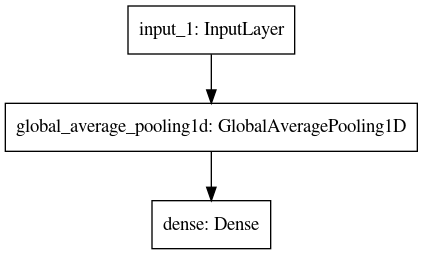

In [96]:
tf.keras.utils.plot_model(mlp, show_shapes=False, show_dtype=False,
                          show_layer_names=True, rankdir='TB', 
                          expand_nested=False, dpi=96)

### Defining metric for testing the predicted and actual genres.
The metric first calculates the accuracy on each predicted output vector by comparing it with the actual output vector. If all the 42 elements of predicted and actual vectors are the same, the accuracy is 100%. The accuracy decreases as more elements mismatch in the predicted and the actual vector.

The accuracy score is calculated as the mean of all the accuracies obtained on the batch of data passed.

![](https://miro.medium.com/max/1400/1*_qeJQPY9CKki2xouAQr6fg.png)

In [97]:
from sklearn.metrics import accuracy_score
def get_accuracy(y, y_pred):
    acc = []
    for i,j in zip(y, y_pred):
        acc.append(accuracy_score(i,j))
    return np.mean(acc)

def accuracy(y, y_pred):
    return tf.py_function(get_accuracy, (y, tf.cast((y_pred>0.5), tf.float32)), tf.double)

In [98]:
from tensorflow.keras import optimizers
metrics = [accuracy]
mlp.compile(optimizer=optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=metrics)

In [99]:
y_train_output = np.vstack(y_train.values)
y_test_output = np.vstack(y_test.values)
y_val_output = np.vstack(y_val.values)

In [100]:
history = mlp.fit(X_train_pooled_output, y_train_output, epochs=40, 
                  validation_data=(X_val_pooled_output, y_val_output))

Epoch 1/40
106/106 [==============================] - 3s 28ms/step - loss: 0.5716 - accuracy: 0.7312 - val_loss: 0.3091 - val_accuracy: 0.9484
Epoch 2/40
106/106 [==============================] - 3s 26ms/step - loss: 0.2745 - accuracy: 0.9482 - val_loss: 0.2068 - val_accuracy: 0.9509
Epoch 3/40
106/106 [==============================] - 3s 25ms/step - loss: 0.1955 - accuracy: 0.9504 - val_loss: 0.1708 - val_accuracy: 0.9522
Epoch 4/40
106/106 [==============================] - 3s 25ms/step - loss: 0.1650 - accuracy: 0.9520 - val_loss: 0.1537 - val_accuracy: 0.9519
Epoch 5/40
106/106 [==============================] - 3s 25ms/step - loss: 0.1519 - accuracy: 0.9516 - val_loss: 0.1436 - val_accuracy: 0.9535
Epoch 6/40
106/106 [==============================] - 3s 26ms/step - loss: 0.1437 - accuracy: 0.9521 - val_loss: 0.1370 - val_accuracy: 0.9538
Epoch 7/40
106/106 [==============================] - 3s 25ms/step - loss: 0.1357 - accuracy: 0.9533 - val_loss: 0.1321 - val_accuracy: 0.9541

### Let's check the performance of our trained model

In [64]:
df_metric = pd.DataFrame()
df_metric['epoch'] = np.arange(len(history.history['auc']))
df_metric['loss'] = history.history['loss']
df_metric['val_loss'] = history.history['val_loss']
df_metric['accuracy'] = history.history['accuracy']
df_metric['val_accuracy'] = history.history['val_accuracy']

### Accuracy score on train and validation data

In [66]:
fig = px.line(df_metric, x="epoch", y=["accuracy", 'val_accuracy'])
fig.show()

### Binary_crossentropy loss on train and validation data

In [67]:
fig = px.line(df_metric, x="epoch", y=["loss", 'val_loss'])
fig.show()

We can see that the model has preformed pretty well and was able to achieve an accuracy over 96% and the losses also reduced to similar values meaning there's no bias or variance issue.

### Below are some samples from the test dataset which has not been seen by our model till now. Let's see how the model performs on these samples.

In [108]:
from sklearn.metrics import accuracy_score
y_pred = (mlp.predict(X_test_pooled_output)>0.5)*1
acc = [accuracy_score(i,j) for i,j in zip(y_pred, y_test)]
idx = np.argsort(acc)[::-1]
def show(i):
    print(f'movie: {X_test.title.values[i]}')
    print(f'description: {X_test.text.values[i]}')
    y_act_idx = unique[np.where(y_test_output[i]==1)]
    y_pred_idx = unique[np.where(y_pred[i]==1)]
    print(f'metric score: {acc[i]}')
    print(f'actual genre: {y_act_idx}')
    print(f'predicted genre: {y_pred_idx}')
    print('\n', '*'*50, '\n')
    
for i in idx[:10]:
    show(i)

movie: Kevin James: Sweat the Small Stuff
description: The film and television star riffs on life's many royal pains in this hourlong special taped at New York City's Hudson Theatre in 2001.
metric score: 1.0
actual genre: ['Stand-Up Comedy']
predicted genre: ['Stand-Up Comedy']

 ************************************************** 

movie: Larceny
description: An ex-CIA contractor turned thief is forced to head a CIA gambit to infiltrate a black ops Mexican prison and steal $50 million in drug cartel money.
metric score: 1.0
actual genre: ['Action & Adventure']
predicted genre: ['Action & Adventure']

 ************************************************** 

movie: Caregiver
description: Sarah leaves her son in the Philippines to reunite with her husband in London, where she struggles personally and professionally as a care-home worker.
metric score: 1.0
actual genre: ['Dramas' 'International Movies']
predicted genre: ['Dramas' 'International Movies']

 ************************************

### Below is the histogram of accuracy scores achieved by the model on the test/unseen dataset.

In [88]:
fig = px.histogram(acc, nbins=20, labels={'value':'Accuracy score'})
fig.show()

### Please upvote if you liked this notebook and suggest improvements in the comments.